# Part 1: How to Explore the GAN Latent Space When Generating Faces (25 pts)

1. Implement SR-GAN on your own using PyTorch. (Ref: https://arxiv.org/abs/1609.04802)

2. Use the ImageNet dataset to run a few epochs to train the model. You may use the script provided here to generate training data: Dataset (https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/srgan/datasets.py). However, there is some issue with this code, hence the drive link for the generated images is shared below. Please use this link to access the dataset for training SRGAN. (https://drive.google.com/drive/folders/13txSH8LU64amnvY0hkxMxMI6F6ssbErG?usp=sharing ) .

Note: you should only use this repo for dataset code and reference. Model and results
(20 pts) + report (5 pts)

In [1]:
import glob
import random
import os
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms


# Configurations

In [2]:
! mkdir trained_model

mkdir: trained_model: File exists


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LOAD_MODEL = True
SAVE_MODEL = True

CHECKPOINT_GEN = "trained_model/gen.pth.tar"
CHECKPOINT_DISC = "trained_model/disc.pth.tar"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 1e-4
NUM_EPOCHS = 32
BATCH_SIZE = 16

HIGH_RES = 96
LOW_RES = HIGH_RES // 4
IMG_CHANNELS = 3


base_data_path = "/Users/hims/Downloads/SRGAN_Data/"

# Data Loading And Transformation

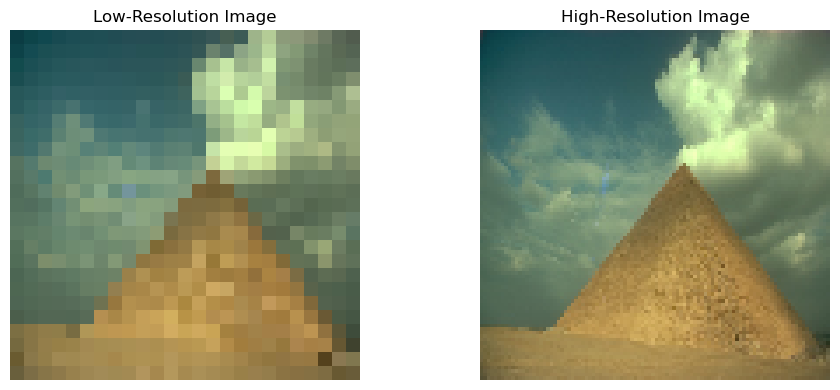

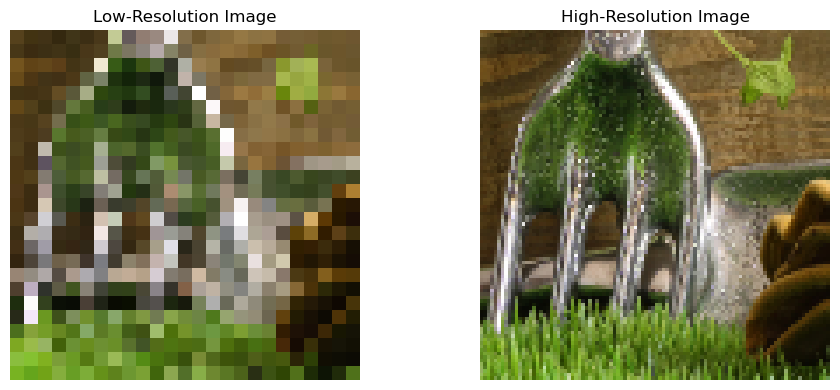

In [4]:
import matplotlib.pyplot as plt

def show_samples(data_path):
    lr_files = os.listdir(data_path + "/LR/")
    hr_files = os.listdir(data_path + "/HR/")
    
    
    for i in range(2):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        image = Image.open(os.path.join(data_path + "/LR/", lr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Low-Resolution Image')

        plt.subplot(1, 2, 2)
        image = Image.open(os.path.join(data_path + "/HR/", hr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('High-Resolution Image')
        
        plt.tight_layout()
        plt.show()        
        
show_samples(base_data_path)

In [5]:
low_res_image = os.listdir(base_data_path + "/LR/")[0]
print("Low Resolution Image size = ", Image.open(os.path.join(base_data_path + "/LR/", low_res_image)).size)

hish_res_image = os.listdir(base_data_path + "/HR/")[0]
print("High Resolution Image size = ", Image.open(os.path.join(base_data_path + "/HR/", hish_res_image)).size)

Low Resolution Image size =  (25, 25)
High Resolution Image size =  (100, 100)


In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImagePairDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        self.lr_transform = transforms.Compose([
            transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_height, hr_height), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

        self.lr_files = sorted(glob.glob(root + "/LR/*.*"))
        self.hr_files = sorted(glob.glob(root + "/HR/*.*"))
        
        print(f"Number of low res images = {len(self.lr_files)}, and High res images = {len(self.hr_files)}")
        
        print("Image Sizes After transformation")
        print("Low Resolution Image size = ", self.lr_transform(Image.open(self.lr_files[0])).shape)
        print("High Resolution Image size = ", self.hr_transform(Image.open(self.hr_files[0])).shape)

    def __getitem__(self, index):
        img_lr = Image.open(self.lr_files[index])
        img_hr = Image.open(self.hr_files[index])

        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.lr_files)  # Each pair counts as one sample



dataset = ImagePairDataset(base_data_path, hr_shape=(96, 96))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Data Load is created with batch_size = {len(dataloader)}")

Number of low res images = 509, and High res images = 509
Image Sizes After transformation
Low Resolution Image size =  torch.Size([3, 24, 24])
High Resolution Image size =  torch.Size([3, 96, 96])
Data Load is created with batch_size = 32


# Model

![Image Title](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-19_at_11.13.45_AM_zsF2pa7.png)

In [7]:
import torch
from torch import nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation_func=None, normalize=True, bias=True, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels, out_channels, bias=bias, **kwargs)
        self.batchNorm = nn.BatchNorm2d(out_channels) if normalize else nn.Identity()
        self.activation_func = activation_func
        

    def forward(self, x):
        out = self.cnn(x)
        out = self.batchNorm(out)
        if self.activation_func is not None:
            out = self.activation_func(out)
        return out


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # self.activation_func = nn.PReLU(num_parameters=in_channels)
        # first three layer of the residual block
        self.block_with_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1, activation_func=nn.PReLU(num_parameters=in_channels))
        # later 2 layer of the residual block
        self.block_wo_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.block_with_act(x)
        out = self.block_wo_act(out)
        return out + x


class PixelShufflerBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        out_channels = in_channels * scale_factor ** 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1) # in_c * 4, H, W --> in_c, H*2, W*2
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.activation_function = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.activation_function(out)
        return out


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_res_blocks=16, num_pix_shuffle_blocks=2):
        super().__init__()
        self.first_layer = ConvBlock(in_channels, num_channels, activation_func=nn.PReLU(num_parameters=num_channels), kernel_size=9, stride=1, padding=4, normalize=False)
        self.residual_layer = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_res_blocks)])
        self.conv_layer = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle_layer = nn.Sequential(*[PixelShufflerBlock(num_channels, scale_factor=2) for _ in range(num_pix_shuffle_blocks)])
        self.output_layer = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.first_layer(x)
        out = self.residual_layer(initial)
        out = self.conv_layer(out) + initial
        out = self.pixel_shuffle_layer(out)
        out = self.output_layer(out)
        # out = torch.tanh(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        activation_func = nn.LeakyReLU(0.2)
        self.layers = nn.Sequential(*[
            ConvBlock(in_channels, 64,  activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=False),
            ConvBlock(64,  64,  activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(64,  128, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(128, 128, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(128, 256, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(256, 256, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(256, 512, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(512, 512, activation_func=nn.LeakyReLU(0.2), kernel_size=3, stride=2, padding=1, normalize=True)
        ])
        self.classifier = nn.Sequential(
            # nn.AdaptiveAvgPool2d((6, 6)),
            # nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        # x = self.layers(x)
        
        out = self.layers(x)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        
        return out


def test():

    with torch.cuda.amp.autocast():
        x = torch.randn((5, 3, LOW_RES, LOW_RES))
        gen = Generator()
        gen_out = gen(x)
        # print(gen)
        print(gen_out.shape)
        disc = Discriminator()
        # print(disc)
        disc_out = disc(gen_out)
        print(disc_out.shape)


test()

torch.Size([5, 3, 96, 96])


/Users/hims/anaconda3/envs/python310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


torch.Size([5, 1])


In [8]:
from torchsummary import summary
print(Generator())
summary(Generator(), (3, 24, 24))

Generator(
  (first_layer): ConvBlock(
    (cnn): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (batchNorm): Identity()
    (activation_func): PReLU(num_parameters=64)
  )
  (residual_layer): Sequential(
    (0): ResidualBlock(
      (block_with_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_func): PReLU(num_parameters=64)
      )
      (block_wo_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (block_with_act): ConvBlock(
        (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
print(Discriminator())
summary(Discriminator(), (3, 96, 96))

Discriminator(
  (layers): Sequential(
    (0): ConvBlock(
      (cnn): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm): Identity()
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (1): ConvBlock(
      (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (2): ConvBlock(
      (cnn): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0.2)
    )
    (3): ConvBlock(
      (cnn): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (batchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_func): LeakyReLU(negative_slope=0

# VGG Loss

In [10]:
import torch.nn as nn
from torchvision.models import vgg19

class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval().to(DEVICE)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input_data, target):
        vgg_input_features = self.vgg(input_data)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

# Utils Functions

In [11]:
import torch
import os
import numpy as np
from PIL import Image
from torchvision.utils import save_image


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print(f"=> Saving checkpoint {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    if os.path.exists(checkpoint_file):
        print("=> Loading checkpoint")
        checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    else:
        print("File does not exist.")
    
    return model, optimizer


# Traing Evaluations

In [12]:
def generated_output(G, image):
    ts = transforms.Compose([
            transforms.Resize((24, 24), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    
    upscaled_img = ts(image).unsqueeze(0)
    gen_output = G(upscaled_img)
    gen_output = (gen_output.squeeze().permute(1, 2, 0).cpu().detach().numpy()+1) * 0.5    
    return upscaled_img, gen_output
    

def plot_examples(data_path, G):
    
    lr_files = os.listdir(data_path + "/LR/")
    hr_files = os.listdir(data_path + "/HR/")
    
    
    for i in range(2):
        plt.figure(figsize=(15, 4))
        
        plt.subplot(1, 4, 1)
        image = Image.open(os.path.join(data_path + "/LR/", lr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Low-Resolution Image')

        transformed_lr, generated_img = generated_output(G, image)
        
        plt.subplot(1, 4, 2)
        plt.imshow((transformed_lr.squeeze().permute(1, 2, 0).cpu().numpy() + 1) * 0.5)
        plt.axis('off')
        plt.title('Transformed Image')
        
        plt.subplot(1, 4, 3)
        plt.imshow(generated_img)
        plt.axis('off')
        plt.title('Generatd Image')
        
        plt.subplot(1, 4, 4)
        image = Image.open(os.path.join(data_path + "/HR/", hr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('High-Resolution Image')
        
        plt.tight_layout()
        plt.show()       
        

# Training Model

In [13]:
import torch
# import config
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.backends.cudnn.benchmark = True


def train_epoch(loader, D, G, opt_gen, opt_disc, mse_loss, bce_loss, vgg_loss_fun):
    
    training_metric = {"g_loss": [], "d_loss": [], "vgg_loss": [], "l2_loss": []}
    for i, imgs in enumerate(loader):
        low_res = imgs['lr'].to(DEVICE)
        high_res = imgs['hr'].to(DEVICE)
        
        ### Train Discriminator
        opt_disc.zero_grad()
        
        output = G(low_res)
        d_real = D(high_res)
        d_fake = D(output.detach())
        
        d_real_loss = bce_loss(d_real, torch.ones_like(d_real))# - 0.1 * torch.rand_like(d_real))
        d_fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))
        d_loss = (d_real_loss + d_fake_loss)/2

        # opt_disc.zero_grad()
        d_loss.backward()
        opt_disc.step()

        # Train Generator
        opt_gen.zero_grad()
        
        output = G(low_res)
        d_fake = D(output)
        
        adversarial_loss = 1e-3 * bce_loss(d_fake, torch.ones_like(d_fake))
        vgg_loss = vgg_loss_fun(output, high_res) * 0.006
        g_loss = adversarial_loss + vgg_loss
        l2_loss = mse_loss(output, high_res)
        
        g_loss.backward()
        opt_gen.step()
        
        print(f"\t{g_loss.item() = }, {vgg_loss.item() = }, {d_loss.item() = }")
        training_metric["g_loss"].append(g_loss.item())
        training_metric["d_loss"].append(d_loss.item())
        training_metric["vgg_loss"].append(vgg_loss.item())
        training_metric["l2_loss"].append(l2_loss.item())

    return training_metric, D, G, opt_gen, opt_disc 

/Users/hims/anaconda3/envs/python310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hims/anaconda3/envs/python310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


	g_loss.item() = 0.007979614660143852, vgg_loss.item() = 0.005864914506673813, d_loss.item() = 0.7127881646156311
	g_loss.item() = 0.008335285820066929, vgg_loss.item() = 0.004778397735208273, d_loss.item() = 0.57669597864151
	g_loss.item() = 0.006861847825348377, vgg_loss.item() = 0.005100551061332226, d_loss.item() = 0.5429989695549011
	g_loss.item() = 0.008928637951612473, vgg_loss.item() = 0.007284271996468306, d_loss.item() = 0.36720964312553406
	g_loss.item() = 0.009060884825885296, vgg_loss.item() = 0.006038794759660959, d_loss.item() = 0.37422671914100647
	g_loss.item() = 0.012553724460303783, vgg_loss.item() = 0.008079206570982933, d_loss.item() = 0.1858460009098053
	g_loss.item() = 0.01324455812573433, vgg_loss.item() = 0.008311263285577297, d_loss.item() = 0.15095371007919312
	g_loss.item() = 0.011328674852848053, vgg_loss.item() = 0.006507374811917543, d_loss.item() = 0.15974774956703186
	g_loss.item() = 0.009186825715005398, vgg_loss.item() = 0.004586074501276016, d_loss.i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


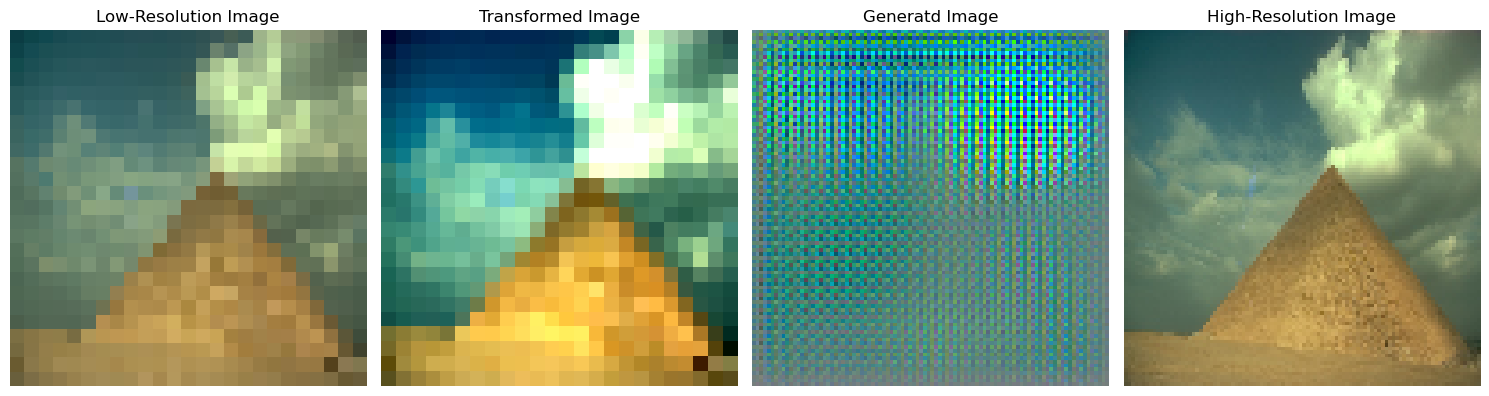

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


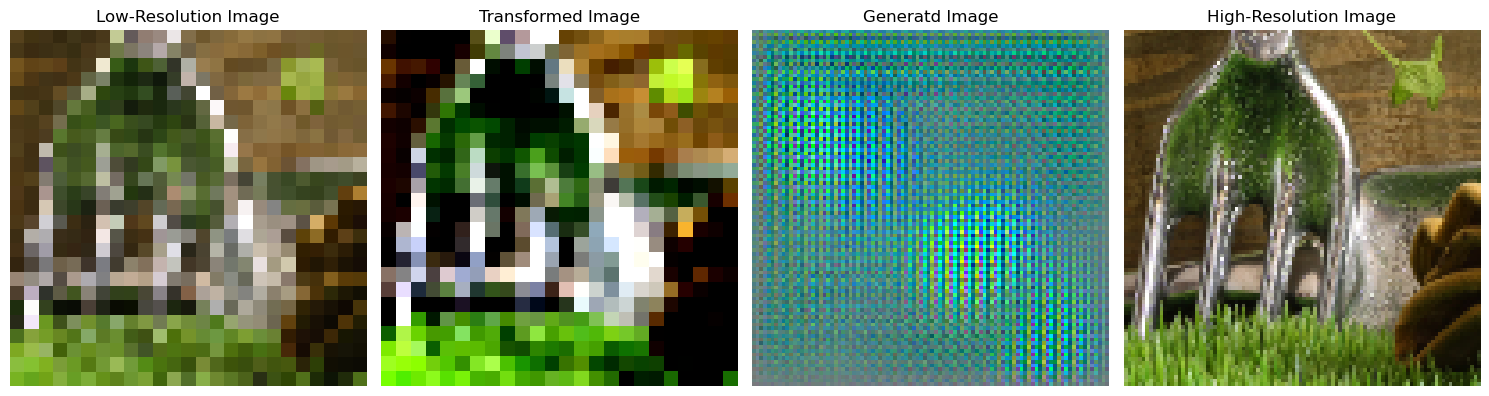

	g_loss.item() = 0.020529597997665405, vgg_loss.item() = 0.00784741435199976, d_loss.item() = 0.015786243602633476
	g_loss.item() = 0.019755983725190163, vgg_loss.item() = 0.004616664256900549, d_loss.item() = 0.1285705268383026
	g_loss.item() = 0.022231116890907288, vgg_loss.item() = 0.006030466873198748, d_loss.item() = 0.009254880249500275
	g_loss.item() = 0.024537384510040283, vgg_loss.item() = 0.007831830531358719, d_loss.item() = 0.0001410497643519193
	g_loss.item() = 0.022507183253765106, vgg_loss.item() = 0.006562675349414349, d_loss.item() = 0.0018627193057909608
	g_loss.item() = 0.02265210449695587, vgg_loss.item() = 0.0072184037417173386, d_loss.item() = 0.007069841027259827
	g_loss.item() = 0.0207647904753685, vgg_loss.item() = 0.00608220137655735, d_loss.item() = 0.0007179714739322662
	g_loss.item() = 0.022667620331048965, vgg_loss.item() = 0.0054604653269052505, d_loss.item() = 0.3109641373157501
	g_loss.item() = 0.026333604007959366, vgg_loss.item() = 0.00627192761749029

In [ ]:
G = Generator().to(DEVICE)
G_optimizer = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))

D = Discriminator().to(DEVICE)
D_optimizer = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))


if False:
    load_checkpoint(CHECKPOINT_GEN, G, G_optimizer, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_DISC, D, D_optimizer, LEARNING_RATE)
    print("Loaded Model Successfully")

training_metric = {"g_loss": [], "d_loss": [], "vgg_loss": [], "l2_loss": []}

for epoch in range(10):
    epoch_metric, D, G, G_optimizer, D_optimizer = train_epoch(dataloader, D, G, G_optimizer, D_optimizer, 
                                                               nn.MSELoss(), nn.BCEWithLogitsLoss(), VGGLoss())

    for key in epoch_metric.keys():
        training_metric[key].append(np.mean(epoch_metric[key]))
    print(f"{epoch = }", {k: training_metric[k][-1] for k in training_metric.keys()})

    if SAVE_MODEL:
        save_checkpoint(G, G_optimizer, filename=CHECKPOINT_GEN)
        save_checkpoint(D, D_optimizer, filename=CHECKPOINT_DISC)
        
    plot_examples(base_data_path, G)

# Model Evaluation

In [ ]:
def plot_training_metrics(training_metric):
    num_epochs = len(training_metric['g_loss'])
    epochs = np.arange(1, num_epochs + 1)  # Assuming start from 1, adjust if needed

    # Plotting side by side without epoch axis
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # Plot g_loss
    axs[0].plot(epochs, training_metric['g_loss'], marker='o')
    axs[0].set_title('Generator Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    # Plot d_loss
    axs[1].plot(epochs, training_metric['d_loss'], marker='o')
    axs[1].set_title('Discriminator Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')

    # Plot vgg_loss
    axs[2].plot(epochs, training_metric['vgg_loss'], marker='o')
    axs[2].set_title('VGG Loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Loss')

    # Plot l2_loss
    axs[3].plot(epochs, training_metric['l2_loss'], marker='o')
    axs[3].set_title('L2 Loss')
    axs[3].set_xlabel('Epochs')
    axs[3].set_ylabel('Loss')

    plt.tight_layout()
    plt.show()
    
plot_training_metrics(training_metric)

In [ ]:
print("Showing Sample images generated by the model")
plot_examples(base_data_path, G)